<a href="https://colab.research.google.com/github/eabarnes1010/ml_tutorial_ncat/blob/main/code/Predict_ENSO_regression_w_lead.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a neural network to predict the value of the Nino34 index
## Explore differences of prediction skill with various preprocessing methods

##### SST mean data downloaded from NOAA NCEI Extended Reconstructed Sea Surface Temperature
* https://psl.noaa.gov/data/gridded/data.noaa.ersst.v5.html

##### Nino34 Index calculation computed generally following below website, but included detrending data
* https://foundations.projectpythia.org/core/xarray/enso-xarray.html

In [1]:
%pip install seaborn cartopy fsspec requests aiohttp h5netcdf wget

import wget

import xarray as xr
import fsspec
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.colors as mcolors

import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
from sklearn.metrics import confusion_matrix

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Set random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# 1. Load and Inspect Data

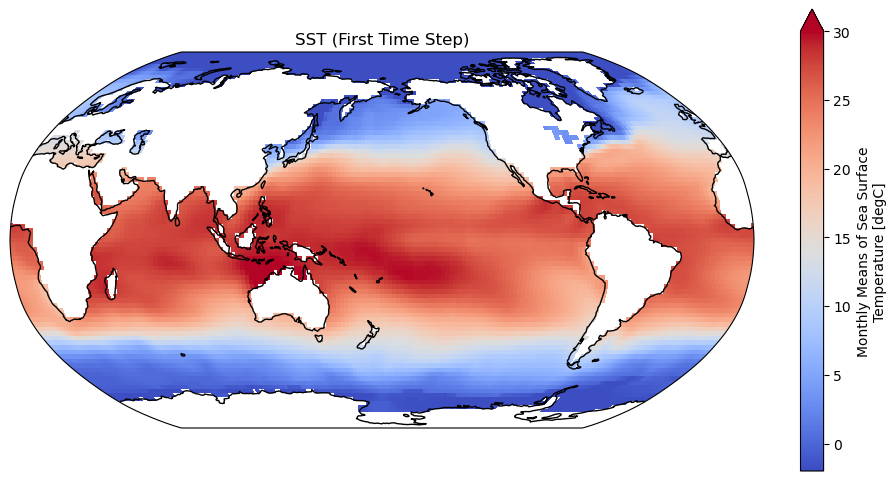

In [3]:
# Download SST dataset
url = "https://downloads.psl.noaa.gov/Datasets/noaa.ersst.v5/sst.mnmean.nc"
sst_data_raw = xr.open_dataset(fsspec.open(url).open())
sst_ds = sst_data_raw.sst

# Plot the first time step of the SST data
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.coastlines()
sst_ds.isel(time=0).plot(
    ax=ax, transform=ccrs.PlateCarree(), vmin=-2, vmax=30, cmap="coolwarm"
)
plt.title("SST (First Time Step)")
plt.show()

# 2. Define Data Splits

In [4]:
exp_name = "clean"

# Define the training, validation, and testing periods
train_start, train_end = "1854-01-01", "1980-03-01"
val_start, val_end = "1980-09-01", "2001-03-01"
test_start, test_end = "2001-09-01", "2024-7-01"

lead = 4  # number of months ahead to predict

# If the data split is sequential, defining the y-masks isn't necessary
# But if time periods are skipped between skips, this is needed
train_start_y, train_end_y = "1854-05-01", "1980-07-01"
val_start_y, val_end_y = "1981-01-01", "2001-07-01"
test_start_y, test_end_y = "2002-01-01", "2024-11-01"
# ----------------------------

# Split the data into training, validation, and testing sets
train_data = sst_ds.sel(time=slice(train_start, train_end))
val_data = sst_ds.sel(time=slice(val_start, val_end))
test_data = sst_ds.sel(time=slice(test_start, test_end))

# 3. Compute and Remove Monthly Climatology

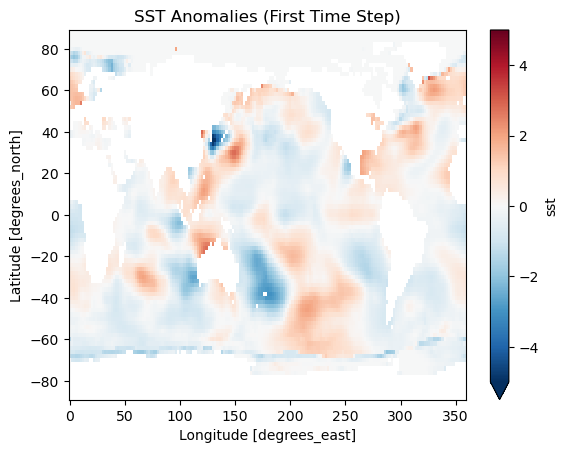

In [5]:
# Compute climatology (1950–1979 baseline period, within training period)
climo_period = train_data.sel(time=slice("1950-01-01", "1979-12-01"))
climatology = climo_period.groupby("time.month").mean(dim="time")

# Remove climatology to calculate anomalies
sst_anomalies = sst_ds.groupby("time.month") - climatology

# Plot anomalies for verification
sst_anomalies.isel(time=0).plot(vmin=-5, vmax=5, cmap="RdBu_r")
plt.title("SST Anomalies (First Time Step)")
plt.show()

# 4. Extract Nino 3.4 Region

Text(0.5, 1.0, 'Niño 3.4 Index Phases')

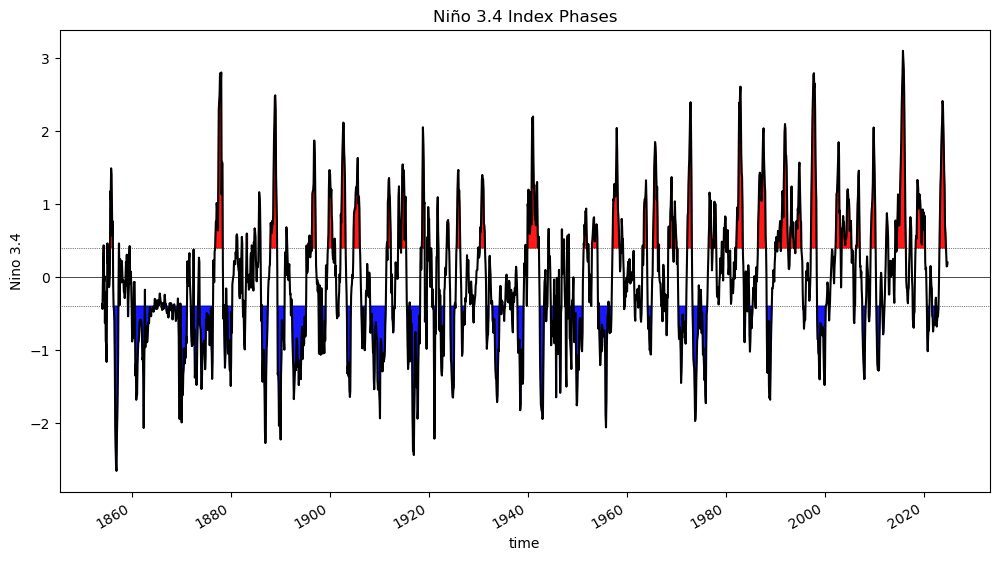

In [6]:
# Define Nino 3.4 region (5°N–5°S, 170°W–120°W)
nino34_region = sst_anomalies.sel(lat=slice(5, -5), lon=slice(190, 240))

# Compute area-weighted average SST anomalies over Nino 3.4 region
weights = np.cos(np.deg2rad(nino34_region["lat"]))
nino34_index = nino34_region.weighted(weights).mean(("lon", "lat"))

fig = plt.figure(figsize=(12, 6))

plt.fill_between(
    nino34_index.time.data,
    nino34_index.where(nino34_index >= 0.4).data,
    0.4,
    color="red",
    alpha=0.9,
)
plt.fill_between(
    nino34_index.time.data,
    nino34_index.where(nino34_index <= -0.4).data,
    -0.4,
    color="blue",
    alpha=0.9,
)

nino34_index.plot(color="black")
plt.ylabel("Nino 3.4")
plt.axhline(0, color="black", lw=0.5)
plt.axhline(0.4, color="black", linewidth=0.5, linestyle="dotted")
plt.axhline(-0.4, color="black", linewidth=0.5, linestyle="dotted")
plt.title("Niño 3.4 Index Phases")

# 5. Detrend Data

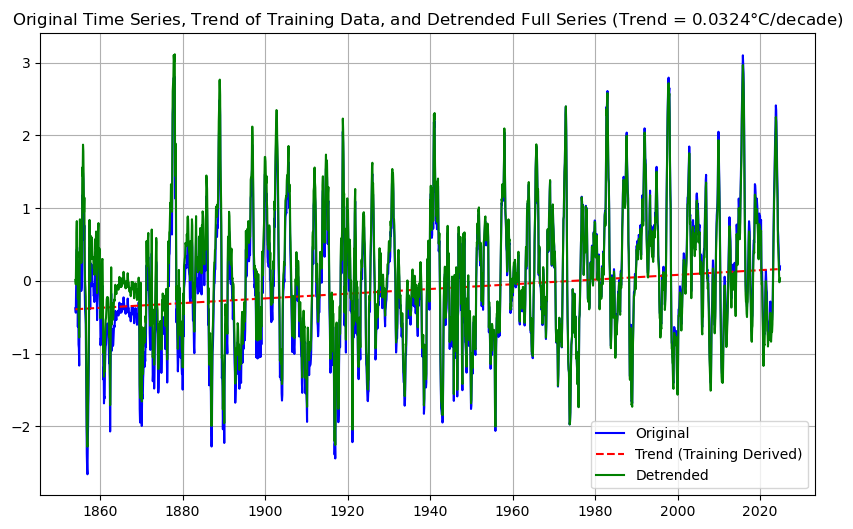

In [7]:
# Convert training time to numeric values for linear regression
time_numeric = np.arange(len(train_data.time))
coeffs = np.polyfit(
    time_numeric, nino34_index.sel(time=slice(train_start, train_end)), 1
)
# time_numeric = np.arange(len(nino34_index.time))
# coeffs = np.polyfit(
#     time_numeric, nino34_index.sel(time=slice(train_start, test_end_y)), 1
# )
slope, intercept = coeffs

# Compute trend over the full dataset
time_numeric_full = np.arange(len(nino34_index.time))
trend = slope * time_numeric_full + intercept

# Remove the trend from the full dataset
nino34_detrended = nino34_index - trend

# Plot detrended index
plt.figure(figsize=(10, 6))
plt.plot(nino34_index.time, nino34_index, label="Original", color="blue")
plt.plot(
    nino34_index.time,
    trend,
    label="Trend (Training Derived)",
    linestyle="--",
    color="red",
)
plt.plot(nino34_index.time, nino34_detrended, label="Detrended", color="green")
# plt.title("Nino 3.4 Index: Original, Trend, and Detrended")
plt.title(
    f"Original Time Series, Trend of Training Data, and Detrended Full Series (Trend = {slope*120:.4f}"  # 12 months * 10 years
    + r"$\degree$C/decade)"
)
plt.legend()
plt.grid()
plt.show()

# 6. Smooth Data

In [8]:
# Apply 5-month rolling mean
nino34_smoothed = nino34_detrended.rolling(time=5, center=False).mean()

# Drop NaNs introduced by rolling mean
nino34_smoothed = nino34_smoothed.dropna(dim="time")

# 7. Shift Data to Account for Lead Time

In [9]:
# Convert to datetime
train_start_date = pd.to_datetime(train_start)
train_end_date = pd.to_datetime(train_end)
val_start_date = pd.to_datetime(val_start)
val_end_date = pd.to_datetime(val_end)
test_start_date = pd.to_datetime(test_start)
test_end_date = pd.to_datetime(test_end)

train_start_date_y = pd.to_datetime(train_start_y)
train_end_date_y = pd.to_datetime(train_end_y)
val_start_date_y = pd.to_datetime(val_start_y)
val_end_date_y = pd.to_datetime(val_end_y)
test_start_date_y = pd.to_datetime(test_start_y)
test_end_date_y = pd.to_datetime(test_end_y)

# Prepare the data: input is all months except the x-lead last months; output is shifted by the lead
if lead == 0:
    nino34_X = nino34_smoothed
    nino34_Y = nino34_smoothed
else:
    nino34_X = nino34_smoothed[:-lead]
    nino34_Y = nino34_smoothed[
        lead:
    ]  # All but the x-lead month (output is shifted by lead)

# Ensure nino34_X and nino34_Y are the same length and time-aligned
nino34_X["time"] = nino34_X.time.values  # Align nino34_X's time with its original time
nino34_Y["time"] = nino34_Y.time.values  # Ensure nino34_Y has the correct time values

# 8. Create Lagged Features

In [10]:
def create_lagged_features(nino34_X, lag_steps):
    """
    Create lagged features from a 1D xarray.DataArray, ensuring proper alignment
    with past data.

    Args:
        nino34_X (xarray.DataArray): Input data of shape (time,).
        lag_steps (int): Number of lag steps to include.

    Returns:
        X_features (xarray.DataArray): Expanded data with shape (time - lag_steps + 1, lag_steps),
                                       aligned with past data.
    """
    # Create lagged arrays by shifting nino34_X forward in time
    lagged_list = [
        nino34_X.shift(time=lag).assign_coords(lag=lag) for lag in range(lag_steps)
    ]
    X_features = xr.concat(
        lagged_list, dim="lag"
    )  # Combine lagged arrays along a new 'lag' dimension
    X_features = X_features.transpose(
        "time", "lag"
    )  # Transpose dimensions to (time, lag)
    X_features["lag"] = range(
        lag_steps
    )  # Ensure lag dimension has descriptive labels (e.g., lag 0 = no lag, lag 1 = 1-step lag, etc.)
    X_features = X_features.isel(
        time=slice(lag_steps - 1, None)
    )  # Drop the first `lag_steps - 1` rows where data is incomplete

    return X_features


lag_steps = 4

# Create lagged features
nino34_X = create_lagged_features(nino34_X, lag_steps)
nino34_Y = nino34_Y[
    lag_steps - 1 :
]  # Drop the first `lag_steps - 1` rows from the output

# 9. Create Data Splits for Training, Validation, and Testing

In [11]:
# Create boolean masks to select data by time using the defined periods
train_mask_X = (nino34_X.time >= train_start_date) & (nino34_X.time <= train_end_date)
val_mask_X = (nino34_X.time >= val_start_date) & (nino34_X.time <= val_end_date)
test_mask_X = (nino34_X.time >= test_start_date) & (nino34_X.time <= test_end_date)

train_mask_Y = (nino34_Y.time >= train_start_date_y) & (
    nino34_Y.time <= train_end_date_y
)
val_mask_Y = (nino34_Y.time >= val_start_date_y) & (nino34_Y.time <= val_end_date_y)
test_mask_Y = (nino34_Y.time >= test_start_date_y) & (nino34_Y.time <= test_end_date_y)

# Apply masks to get training, validation, and testing sets (dropping the unmatched time points)
X_train = nino34_X.where(train_mask_X, drop=True)
X_val = nino34_X.where(val_mask_X, drop=True)
X_test = nino34_X.where(test_mask_X, drop=True)

Y_train = nino34_Y.where(train_mask_Y, drop=True)
Y_val = nino34_Y.where(val_mask_Y, drop=True)
Y_test = nino34_Y.where(test_mask_Y, drop=True)

# Can use this for sequential splits with no gaps
# Y_train = nino34_Y[: len(X_train.time)]
# Y_val = nino34_Y[len(X_train.time) : len(X_train.time) + len(X_val.time)]
# Y_test = nino34_Y[len(X_train.time) + len(X_val.time) :]

# Verify shapes
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

X_train shape: (1508, 4), Y_train shape: (1508,)
X_val shape: (247, 4), Y_val shape: (247,)
X_test shape: (275, 4), Y_test shape: (275,)


# 10. Visualize Data Splits

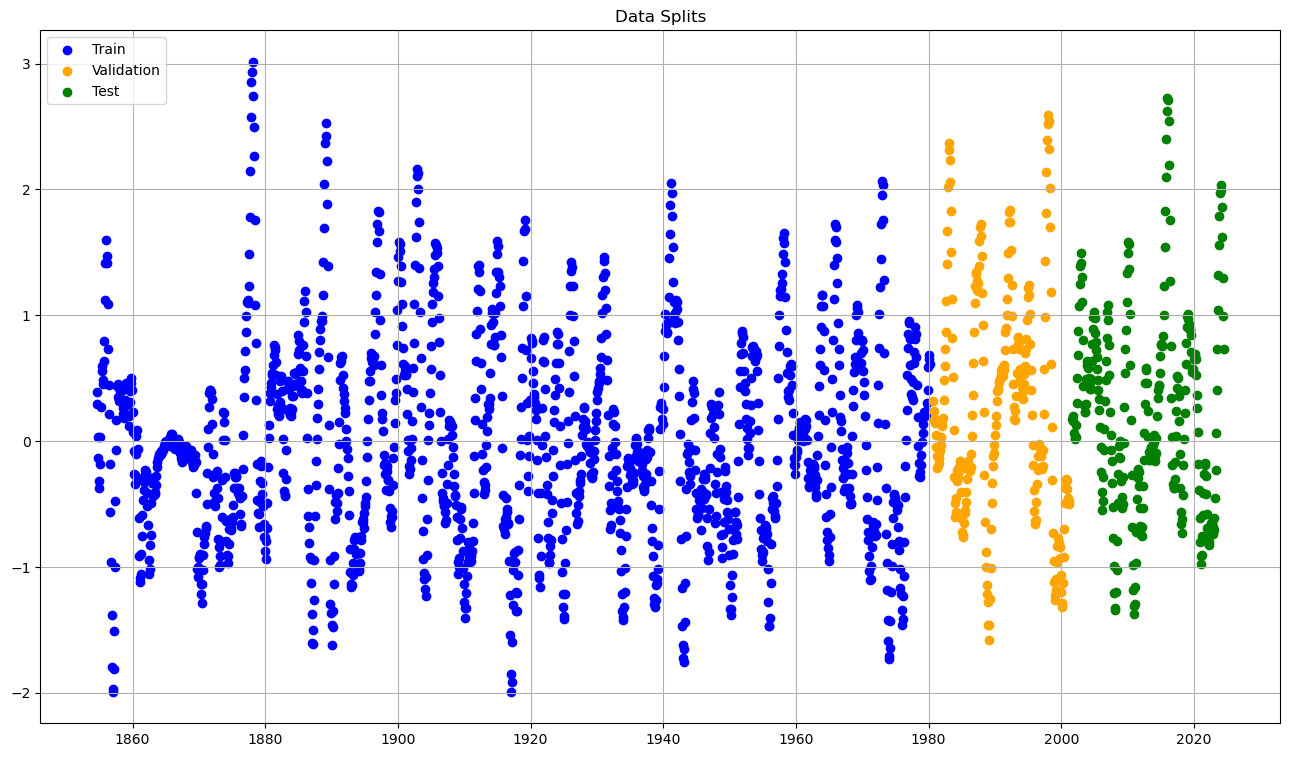

In [12]:
plt.figure(figsize=(16, 9))
plt.scatter(X_train.time, X_train[:, 0], color="blue", label="Train")
plt.scatter(X_val.time, X_val[:, 0], color="orange", label="Validation")
plt.scatter(X_test.time, X_test[:, 0], color="green", label="Test")
plt.title("Data Splits")
plt.legend()
plt.grid()
plt.show()

In [13]:
# =============================
# 11. Normalize Data
# =============================

# Optional step if you want to "standardize" (aka rescale, normalize) the data

# # Normalize SST data using the training standard deviation (sst_std)
# X_std = np.std(X_train, axis=0)

# # Standardize the train, validation, and test data by dividing by sst_std
# X_train = np.divide(X_train, X_std)
# X_train[np.isnan(X_train)] = 0  # Set NaNs to zero in the training data

# X_val = np.divide(X_val, X_std)
# X_val[np.isnan(X_val)] = 0  # Set NaNs to zero in the validation data

# X_test = np.divide(X_test, X_std)
# X_test[np.isnan(X_test)] = 0  # Set NaNs to zero in the test data

# 12. Convert Data to NumPy for Pytorch use

In [14]:
# Convert xarray DataArray to NumPy arrays using the .values attribute
X_train_np = X_train.values  # Extract NumPy array from xarray DataArray
Y_train_np = Y_train.values  # Similarly for labels

X_val_np = X_val.values
Y_val_np = Y_val.values

X_test_np = X_test.values
Y_test_np = Y_test.values

# Reshape the data to ensure each sample has one feature
X_train_np = X_train_np.reshape(-1, len(X_train[0, :]))
X_val_np = X_val_np.reshape(-1, len(X_train[0, :]))
X_test_np = X_test_np.reshape(-1, len(X_train[0, :]))
print("X and Y training shapes")
print(X_train_np.shape)  # Should be (num_samples, num_features)
print(Y_train_np.shape)  # Should be (num_samples,)

X and Y training shapes
(1508, 4)
(1508,)


In [15]:
# Some time stamp checks
print(nino34_index.time)
print("X test time")
print(X_test.time)
print("Y test time")
print(Y_test.time)

<xarray.DataArray 'time' (time: 2051)>
array(['1854-01-01T00:00:00.000000000', '1854-02-01T00:00:00.000000000',
       '1854-03-01T00:00:00.000000000', ..., '2024-09-01T00:00:00.000000000',
       '2024-10-01T00:00:00.000000000', '2024-11-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2024-11-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 12 ... 1 2 3 4 5 6 7 8 9 10 11
X test time
<xarray.DataArray 'time' (time: 275)>
array(['2001-09-01T00:00:00.000000000', '2001-10-01T00:00:00.000000000',
       '2001-11-01T00:00:00.000000000', ..., '2024-05-01T00:00:00.000000000',
       '2024-06-01T00:00:00.000000000', '2024-07-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2001-09-01 2001-10-01 ... 2024-07-01
    month    (time) int64 9 10 11 12 1 2 3 4 5 6 7 ... 9 10 11 12 1 2 3 4 5 6 7
Y test time
<xarray.DataArray 'time' (time: 275)>
array(['2002-01-01T0

# Train the Model 

### The preprocessing of the input and output data is complete. Now, we set up the neural networks to made our predictions.

## Hyperparameter Selection

In [16]:
# Define hyperparameters
input_size = X_train_np.shape[1]
hiddens = [10, 10, 10]
output_size = 1  # only predicting one value for each prediction
learning_rate = 0.0001
n_epochs = 250
batch_size = 64
l2_reg = 0.01  # L2 ridge regularization

In [17]:
class ENSOPredictor_Regression(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size):
        super(
            ENSOPredictor_Regression, self
        ).__init__()  # used to inherit functionality from nn.Module
        self.layers = nn.ModuleList()

        # Add the first hidden layer
        self.layers.append(nn.Linear(input_size, hidden_layers[0]))

        # Add additional hidden layers
        for i in range(1, len(hidden_layers)):
            self.layers.append(nn.Linear(hidden_layers[i - 1], hidden_layers[i]))

        # Add the output layer (no softmax for regression)
        self.layers.append(nn.Linear(hidden_layers[-1], output_size))

    def forward(self, x):
        # Pass input through each hidden layer with ReLU activation
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        # Output layer (no activation for regression)
        return self.layers[-1](x)

Epoch 1/250, Train Loss: 0.6158844021459421, Val Loss: 0.8707452565431595
Epoch 2/250, Train Loss: 0.6097551696002483, Val Loss: 0.8660523295402527
Epoch 3/250, Train Loss: 0.6076668376723925, Val Loss: 0.8608418554067612
Epoch 4/250, Train Loss: 0.6094691343605518, Val Loss: 0.8548312187194824
Epoch 5/250, Train Loss: 0.59513001019756, Val Loss: 0.8485789746046066
Epoch 6/250, Train Loss: 0.5963409245014191, Val Loss: 0.8417890220880508
Epoch 7/250, Train Loss: 0.5902661184469858, Val Loss: 0.8349857777357101
Epoch 8/250, Train Loss: 0.5858447502056757, Val Loss: 0.8269458711147308
Epoch 9/250, Train Loss: 0.5825960462292036, Val Loss: 0.8189028650522232
Epoch 10/250, Train Loss: 0.5777093507349491, Val Loss: 0.8102799206972122
Epoch 11/250, Train Loss: 0.5729368018607298, Val Loss: 0.8012927025556564
Epoch 12/250, Train Loss: 0.5691998439530531, Val Loss: 0.7916713654994965
Epoch 13/250, Train Loss: 0.5641957744956017, Val Loss: 0.782254159450531
Epoch 14/250, Train Loss: 0.559719449

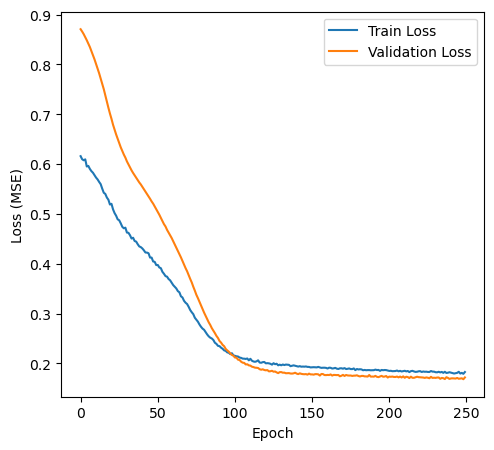

In [18]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).reshape(
    -1, input_size
)
Y_train_tensor = torch.tensor(Y_train.values, dtype=torch.float32).reshape(-1, 1)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).reshape(-1, input_size)
Y_val_tensor = torch.tensor(Y_val.values, dtype=torch.float32).reshape(-1, 1)

# DataLoader for batching
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor),
    batch_size=batch_size,
    shuffle=True,
)

val_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_val_tensor, Y_val_tensor),
    batch_size=batch_size,
    shuffle=False,
)

# Initialize the model, loss function, and optimizer
model = ENSOPredictor_Regression(input_size, hiddens, output_size)
criterion = (
    nn.MSELoss()
)  # alternatives: nn.L1Loss(), nn.SmoothL1Loss(), nn.HuberLoss(), nn.PoissonNLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_reg)

# Training loop
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    running_mse = 0.0
    for inputs, labels in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # Forward pass to get predictions

        # Concatenate the predictions and convert to a tensor
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate validation loss and MSE
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Append the metrics for plotting
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))

    print(
        f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}"
    )

# Plot the training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()
# plt.savefig(f"../figs/training_loss_{exp_name}.png", dpi=300)

## Evaluate the model on the test set

In [19]:
test_data = torch.tensor(X_test_np, dtype=torch.float32)  # Feature data for testing
test_labels = torch.tensor(Y_test_np, dtype=torch.long)  # Testing labels

# Create the test dataset and loader
test_dataset = TensorDataset(test_data, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_data = torch.tensor(X_val_np, dtype=torch.float32)  # Feature data for testing
val_labels = torch.tensor(Y_val_np, dtype=torch.long)  # Testing labels
val_dataset = TensorDataset(val_data, val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

train_data = torch.tensor(X_train_np, dtype=torch.float32)  # Feature data for testing
train_labels = torch.tensor(Y_train_np, dtype=torch.long)  # Testing labels
train_dataset = TensorDataset(train_data, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# Set the model to evaluation mode
model.eval()

# To store predictions and original indices
predictions = []
predictions_val = []
predictions_train = []

original_indices = []
original_indices_val = []
original_indices_train = []

with torch.no_grad():  # No need to track gradients during evaluation
    for batch_idx, (data, labels) in enumerate(test_loader):
        # Get the original indices of the current batch
        original_indices.extend(batch_idx * batch_size + torch.arange(data.size(0)))

        # Forward pass to get predictions
        output = model(data)
        predictions.append(output)

# Concatenate the predictions and convert to a tensor
predictions = torch.cat(predictions, dim=0)

# Convert original indices to a tensor for easy indexing if needed
original_indices = torch.tensor(original_indices)

with torch.no_grad():  # No need to track gradients during evaluation
    for batch_idx, (data, labels) in enumerate(val_loader):
        # Get the original indices of the current batch
        original_indices_val.extend(batch_idx * batch_size + torch.arange(data.size(0)))

        # Forward pass to get predictions
        output_val = model(data)
        predictions_val.append(output_val)

# Concatenate the predictions and convert to a tensor
predictions_val = torch.cat(predictions_val, dim=0)
original_indices_val = torch.tensor(original_indices_val)

with torch.no_grad():  # No need to track gradients during evaluation
    for batch_idx, (data, labels) in enumerate(train_loader):
        # Get the original indices of the current batch
        original_indices_train.extend(
            batch_idx * batch_size + torch.arange(data.size(0))
        )

        # Forward pass to get predictions
        output_train = model(data)
        predictions_train.append(output_train)

# Concatenate the predictions and convert to a tensor
predictions_train = torch.cat(predictions_train, dim=0)
original_indices_train = torch.tensor(original_indices_train)

# #  Now predictions contains the model's outputs, and original_indices contains the indices
# print("Predictions:", predictions)
# print("Original Indices:", original_indices)

# Evaluate the model performance

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


def evaluate_model(loader, model, criterion=None):
    """Evaluate model on the given dataset loader."""
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for data, labels in loader:
            output = model(data)
            all_predictions.append(output)
            all_labels.append(labels)

    all_predictions = torch.cat(all_predictions, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()

    mse = mean_squared_error(all_labels, all_predictions)
    mae = mean_absolute_error(all_labels, all_predictions)

    return mse, mae, all_predictions, all_labels


# Assess performance
train_mse, train_mae, train_preds, train_labels = evaluate_model(train_loader, model)
val_mse, val_mae, val_preds, val_labels = evaluate_model(val_loader, model)
test_mse, test_mae, test_preds, test_labels = evaluate_model(test_loader, model)

print(f"Train MSE: {train_mse}, Train MAE: {train_mae}")
print(f"Val MSE: {val_mse}, Val MAE: {val_mae}")
print(f"Test MSE: {test_mse}, Test MAE: {test_mae}")

Train MSE: 0.24394802525937603, Train MAE: 0.39412686226775856
Val MSE: 0.19136258637748943, Val MAE: 0.33818037964795766
Test MSE: 0.2656205141937988, Test MAE: 0.4241677287220955


## Plot the predictions vs. truth

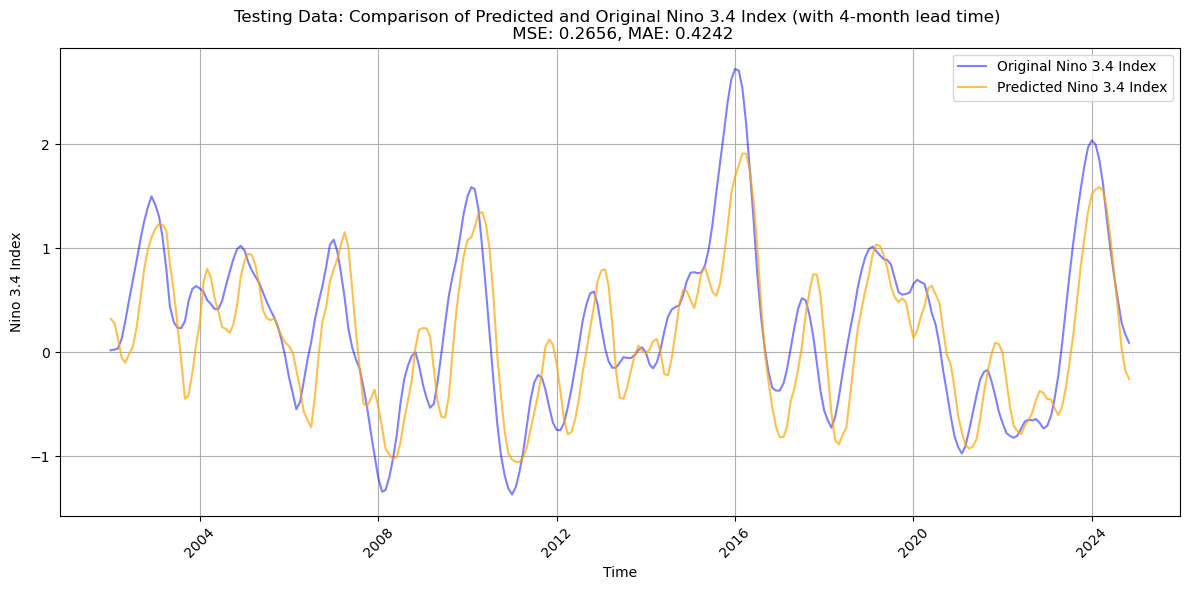

In [21]:
time_nino34 = Y_test.time.values
start_index = len(Y_test) - len(predictions)
time_predictions = time_nino34[start_index:]

# Adjust start_index based on preprocessing
start_index = len(Y_test) - len(predictions)
if start_index < 0:
    raise ValueError("Predictions are longer than Y_test, check preprocessing.")

# Correct alignment of time_predictions
time_predictions = time_nino34[start_index:]  # Ensure timestamps match predictions

# Verify alignment
assert len(time_predictions) == len(
    predictions
), "Timestamps and predictions misaligned!"

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(time_nino34, Y_test, label="Original Nino 3.4 Index", color="blue", alpha=0.5)
plt.plot(
    time_predictions,
    predictions,
    label="Predicted Nino 3.4 Index",
    color="orange",
    alpha=0.7,
)

plt.title(
    "Testing Data: Comparison of Predicted and Original Nino 3.4 Index (with 4-month lead time) \n MSE: {:.4f}, MAE: {:.4f}".format(
        test_mse, test_mae
    )
)
plt.xlabel("Time")
plt.ylabel("Nino 3.4 Index")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# plt.savefig(f"../figs/predictions_test_{exp_name}.png", dpi=300)

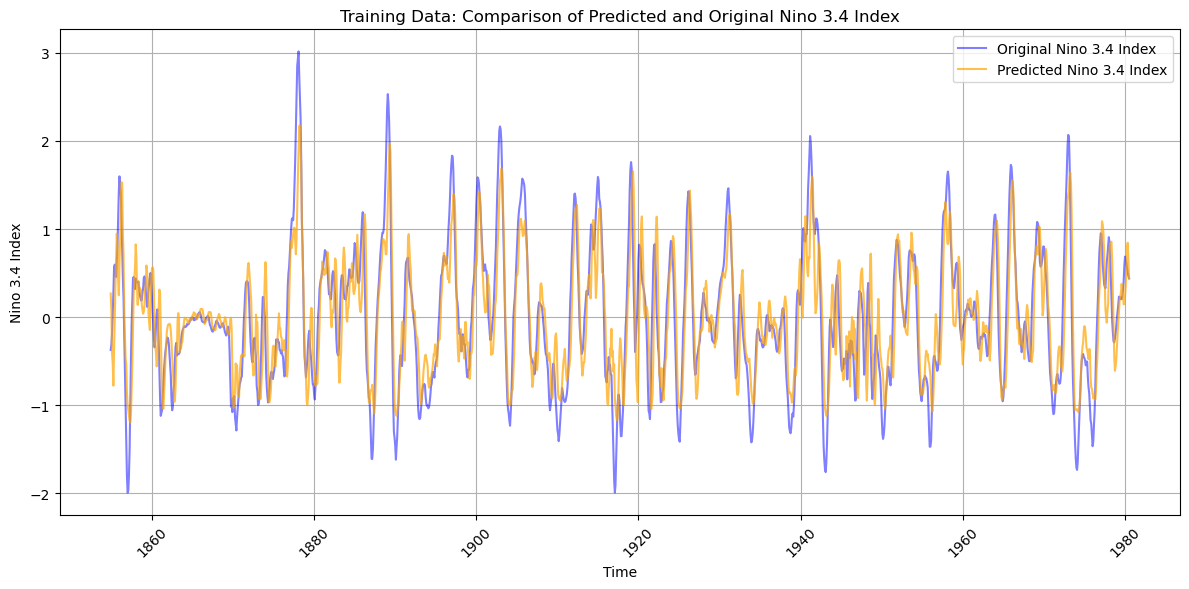

In [22]:
time_nino34 = Y_train.time.values
start_index = len(Y_train) - len(predictions_train)

time_predictions = time_nino34[start_index:]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(time_nino34, Y_train, label="Original Nino 3.4 Index", color="blue", alpha=0.5)
plt.plot(
    time_predictions,
    predictions_train,
    label="Predicted Nino 3.4 Index",
    color="orange",
    alpha=0.7,
)

# Add labels and title
plt.title("Training Data: Comparison of Predicted and Original Nino 3.4 Index")
plt.xlabel("Time")
plt.ylabel("Nino 3.4 Index")
plt.legend()
plt.grid()

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.tight_layout()  # Adjust layout for better fit
plt.show()
# plt.savefig(f"../figs/predictions_train_{exp_name}.png", dpi=300)

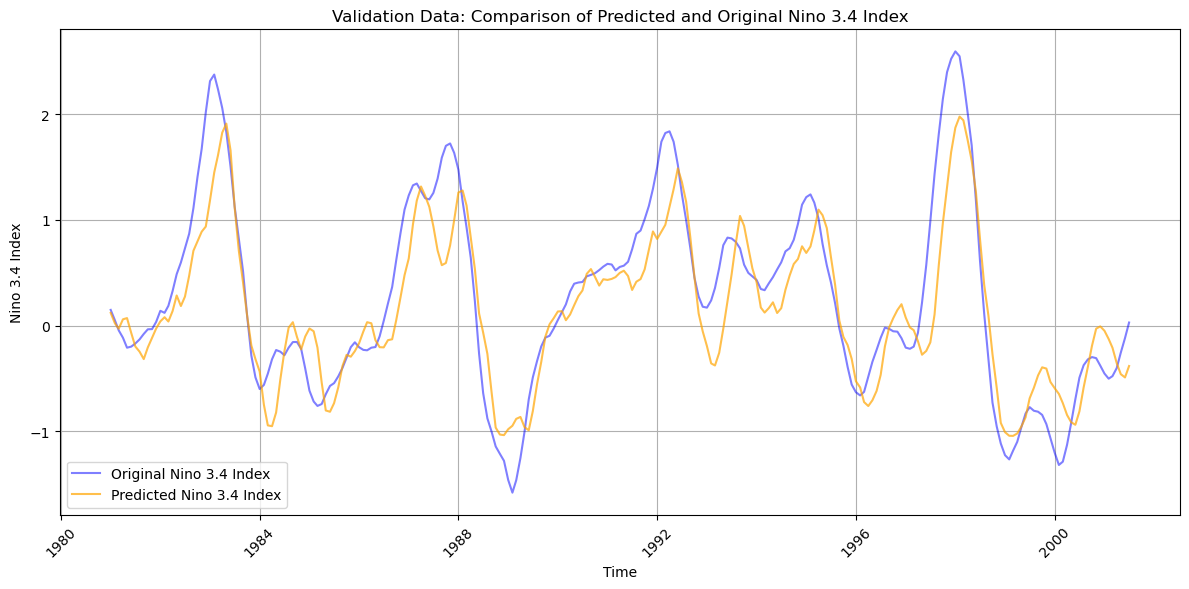

In [23]:
time_nino34 = Y_val.time.values
start_index = len(Y_val) - len(predictions_val)

time_predictions = time_nino34[start_index:]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(time_nino34, Y_val, label="Original Nino 3.4 Index", color="blue", alpha=0.5)
plt.plot(
    time_predictions,
    predictions_val,
    label="Predicted Nino 3.4 Index",
    color="orange",
    alpha=0.7,
)

# Add labels and title
plt.title("Validation Data: Comparison of Predicted and Original Nino 3.4 Index")
plt.xlabel("Time")
plt.ylabel("Nino 3.4 Index")
plt.legend()
plt.grid()

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.tight_layout()  # Adjust layout for better fit
plt.show()
# plt.savefig(f"../figs/predictions_val_{exp_name}.png", dpi=300)

# Save predictions and metrics for future use

In [24]:
# Combine your predictions, labels, and time into a dataset
# Convert everything to NumPy arrays for compatibility with xarray
train_preds_np = train_preds  # Predictions from the training set
val_preds_np = val_preds  # Predictions from the validation set
test_preds_np = test_preds  # Predictions from the test set

train_labels_np = Y_train.values
val_labels_np = Y_val.values
test_labels_np = Y_test.values

ds = xr.Dataset(
    {
        "train_predictions": (
            ["time_train"],
            train_preds_np.squeeze(),
        ),  # Ensure it's 1D
        "train_labels": (["time_train"], train_labels_np.squeeze()),
        "val_predictions": (["time_val"], val_preds_np.squeeze()),
        "val_labels": (["time_val"], val_labels_np.squeeze()),
        "test_predictions": (["time_test"], test_preds_np.squeeze()),
        "test_labels": (["time_test"], test_labels_np.squeeze()),
        "metrics": (
            ["metric_type"],
            [train_mse, train_mae, val_mse, val_mae, test_mse, test_mae],
        ),
    },
    coords={
        "time_train": Y_train.time.values,  # Ensure it matches `train_labels` shape
        "time_val": Y_val.time.values,  # Ensure it matches `val_labels` shape
        "time_test": Y_test.time.values,  # Ensure it matches `test_labels` shape
        "metric_type": [
            "train_mse",
            "train_mae",
            "val_mse",
            "val_mae",
            "test_mse",
            "test_mae",
        ],
    },
)

# Save the dataset to a NetCDF file - need to uncomment line to save
# ds.to_netcdf("../output/predictions_and_metrics_" + exp_name + ".nc")

# Notify completion
# print("Saved predictions and metrics to netcdf")